# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data 


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [2]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('train.csv')

In [4]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [6]:
print('Пропуски в train:')
display(train.isna().sum())

Пропуски в train:


id             0
keyword       44
location    1760
text           0
target         0
dtype: int64

In [7]:
print('Пропуски в test:')
display(test.isna().sum())

Пропуски в test:


id            0
keyword      17
location    773
text          0
target        0
dtype: int64

In [8]:
# Пропуски есть и там, и там, заполним их:
train = train.fillna('')
test = test.fillna('')

In [9]:
print('Пропуски в train:')
display(train.isna().sum())

Пропуски в train:


id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [10]:
print('Пропуски в test:')
display(test.isna().sum())

Пропуски в test:


id          0
keyword     0
location    0
text        0
target      0
dtype: int64

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [11]:
display(train.value_counts('target'))


target
0    3024
1    2305
dtype: int64

* Классы немного не сбалансированны

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [12]:
# Беру отрезок [1; 11), так как в нулевом индексе там пустые слова
popular_keywords = list(train.value_counts('keyword', sort=True)[1:11].index)
display(popular_keywords)

['damage',
 'siren',
 'wreckage',
 'fatalities',
 'deluge',
 'nuclear%20reactor',
 'derail',
 'emergency',
 'fatality',
 'fear']

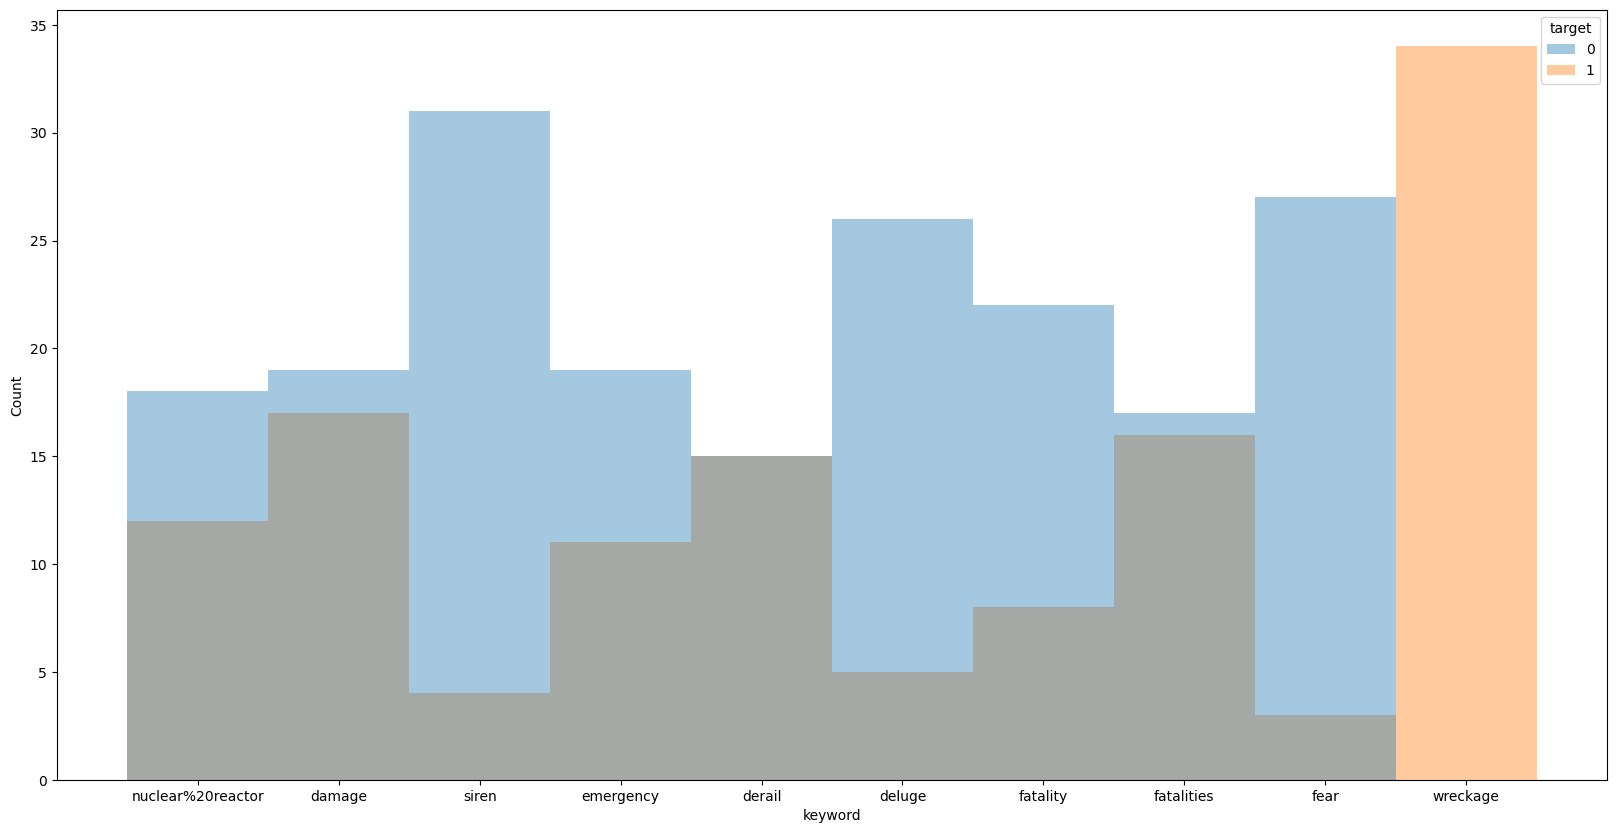

In [13]:
plt.figure(figsize=(20, 10))
sns.histplot(train[train['keyword'].isin(popular_keywords)],
             x='keyword', hue='target', multiple='layer', alpha=0.4, edgecolor=None)
plt.show()

**Выводы**:
* Число твитов о ненастоящей катастрофе больше (оно и ожидаемо, нужно же привлекать к себе внимание на инфоповодах)
* Что примечательно, слово wreckage (крушение) появляется только в твитах о реальных катастрофах. Возможно сложно подделать новость о крушении чего-либо (например самолёта), если ты это не можешь прикрепить никакими кадрами. Ну то есть когда пишешь о крушении, то вероятно читатель ожидает получение фотографий этого крушения. Но это сугубо моё мнение
* Так же странно, что слово derail встречается поровну и в нормальных твитах, и фейковых

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [14]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [15]:
train_new = train.drop('id', axis=1)
test_new = test.drop('id', axis=1)

train_new['concated'] = train_new.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
test_new['concated'] = test_new.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

train_new = train_new.drop(['keyword', 'location', 'text'], axis=1)
test_new = test_new.drop(['keyword', 'location', 'text'], axis=1)

In [16]:
train_new.loc[[6590, 7122, 2769]]

,target,concated
6590,1,"survivors Marietta, GA Stemming from my #Cubs ..."
7122,1,violent%20storm If you were the NWS wth a rot...
2769,0,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [17]:
from sklearn.feature_extraction.text import CountVectorizer

cnt_vec = CountVectorizer()
train_vec = cnt_vec.fit_transform(train_new['concated'])
print('Размерность матрицы:', train_vec.shape)

Размерность матрицы: (5329, 18455)


## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [18]:
import re

In [19]:
def contains_digit(s: str) -> bool:
    # Проверка, содержит ли слово цифры
    return bool(re.search(r'\d', s))

def contains_punctuation(s: str) -> bool:
    # Проверка, содержит ли слово пунктуацию
    return any(char in punctuation for char in s)

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s.startswith('#')

def is_mention(s: str) -> bool:
    # Проверка, является ли слово упоминанием
    return s.startswith('@')


def investigate_vocabulary(vocabulary):
    with_digits = 0
    with_punctuation = 0
    with_hashtag = 0
    with_mention = 0
    for word in vocabulary.keys():
        if contains_digit(word):
            with_digits += 1
        if contains_punctuation(word):
            with_punctuation += 1
        if is_hashtag(word):
            with_hashtag += 1
        if is_mention(word):
            with_mention += 1

    print('With digit:      ', with_digits)
    print('With punctuation:', with_punctuation)
    print('Hashtags:        ', with_hashtag)
    print('Mentions:        ', with_mention)




In [20]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [21]:
investigate_vocabulary(cnt_vec.vocabulary_)

With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [22]:
from nltk.tokenize import TweetTokenizer
help(TweetTokenizer)

Help on class TweetTokenizer in module nltk.tokenize.casual:

class TweetTokenizer(nltk.tokenize.api.TokenizerI)
 |  TweetTokenizer(preserve_case=True, reduce_len=False, strip_handles=False, match_phone_numbers=True)
 |  
 |  Tokenizer for tweets.
 |  
 |      >>> from nltk.tokenize import TweetTokenizer
 |      >>> tknzr = TweetTokenizer()
 |      >>> s0 = "This is a cooool #dummysmiley: :-) :-P <3 and some arrows < > -> <--"
 |      >>> tknzr.tokenize(s0) # doctest: +NORMALIZE_WHITESPACE
 |      ['This', 'is', 'a', 'cooool', '#dummysmiley', ':', ':-)', ':-P', '<3', 'and', 'some', 'arrows', '<', '>', '->',
 |       '<--']
 |  
 |  Examples using `strip_handles` and `reduce_len parameters`:
 |  
 |      >>> tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
 |      >>> s1 = '@remy: This is waaaaayyyy too much for you!!!!!!'
 |      >>> tknzr.tokenize(s1)
 |      [':', 'This', 'is', 'waaayyy', 'too', 'much', 'for', 'you', '!', '!', '!']
 |  
 |  Method resolution order:
 |     

In [23]:
twt_tkn = TweetTokenizer()
cnt_vec_twt = CountVectorizer(tokenizer=twt_tkn.tokenize)
train_vec = cnt_vec_twt.fit_transform(train_new['concated'])

In [24]:
investigate_vocabulary(cnt_vec_twt.vocabulary_)

With digit:       3939
With punctuation: 7338
Hashtags:         1470
Mentions:         1679


**Сравнение:** 
* Токенайзер стал пропускать гораздо больше слов с символами пунктуации в самом слове
* Также токенайзер не разбивает слова при встрече специальных символов в твиттере (хэштега и упоминания)

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [25]:
from nltk.stem.snowball import SnowballStemmer
from string import ascii_letters
import nltk
# nltk.download('stopwords')

In [26]:
brackets = '{([])}'
smiling_symbols = punctuation + brackets
stemm = SnowballStemmer('english')
tweet_tkn = TweetTokenizer()

def contains_only_latin_letters(s: str) -> bool:
    # Проверка, содержит ли слово только латинские буквы
    return all(char in ascii_letters for char in s)


def is_emoji(s: str) -> bool:
    # Проверка, является ли слово смайликом
    return all(char in smiling_symbols for char in s) and any(char in brackets for char in s)


def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s.startswith('#') and s.count('#') == 1


def custom_tokenizer(s: str) -> List[str]:
    s = s.lower()
    bad_tokens = tweet_tkn.tokenize(s)
    result_tokens = []
    for token in bad_tokens:
        if (is_emoji(token) or is_hashtag(token) or contains_only_latin_letters(token)) and token not in nltk.corpus.stopwords.words('english'):
            result_tokens.append(stemm.stem(token))
    return result_tokens

In [27]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [28]:
display(train_new['concated'].head(10).apply(custom_tokenizer))

1186    [bridg, ash, australia, collaps, trent, bridg,...
4071    [hail, carol, stream, illinoi, great, michigan...
5461    [polic, houston, cnn, tennesse, movi, theater,...
5787        [riot, still, riot, coupl, hour, left, class]
7445    [wound, lake, highland, crack, path, wipe, mor...
151     [airplan, somewher, expert, franc, begin, exam...
915     [bloodi, isol, citi, world, perth, came, kill,...
1305                    [burn, except, idk, realli, burn]
2570                  [destroy, (, ask, ), destroy, hous]
7399    [wound, maracay, nirgua, venezuela, polic, off...
Name: concated, dtype: object

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [29]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)
train_vec = vectorizer.fit_transform(train_new['concated'])
test_vec = vectorizer.transform(test_new['concated'])

2. Обучите LogisticRegression на полученных признаках.


In [30]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_vec.toarray(), train_new['target'])

LogisticRegression()

3. Посчитайте метрику f1-score на тестовых данных.

In [31]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

y_pred = lr.predict(test_vec.toarray())


print(classification_report(y_true=test_new['target'], y_pred=y_pred))
print()
print('F1 score:', f1_score(y_true=test_new['target'], y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1318
           1       0.78      0.72      0.75       966

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284


F1 score: 0.752017213555675


## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
train_vec_tf = vectorizer.fit_transform(train_new['concated'])
test_vec_tf = vectorizer.transform(test_new['concated'])

lr = LogisticRegression()
lr.fit(train_vec_tf.toarray(), train_new['target'])

y_pred = lr.predict(test_vec_tf.toarray())


print(classification_report(y_true=test_new['target'], y_pred=y_pred))
print()
print('F1 score:', f1_score(y_true=test_new['target'], y_pred=y_pred))


              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1318
           1       0.80      0.69      0.74       966

    accuracy                           0.80      2284
   macro avg       0.80      0.78      0.79      2284
weighted avg       0.80      0.80      0.79      2284


F1 score: 0.7419354838709677


1. **Ответ:** качество практически не изменилось

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [33]:
# 2
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9)
train_vec_tf = vectorizer.fit_transform(train_new['concated'])
test_vec_tf = vectorizer.transform(test_new['concated'])

lr = LogisticRegression()
lr.fit(train_vec_tf.toarray(), train_new['target'])

y_pred = lr.predict(test_vec_tf.toarray())


print(classification_report(y_true=test_new['target'], y_pred=y_pred))
print()
print('F1 score:', f1_score(y_true=test_new['target'], y_pred=y_pred))


              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1318
           1       0.80      0.69      0.74       966

    accuracy                           0.80      2284
   macro avg       0.80      0.78      0.79      2284
weighted avg       0.80      0.80      0.79      2284


F1 score: 0.7419354838709677


In [34]:
print(train_vec.shape)
print(train_vec_tf.shape)

(5329, 10610)
(5329, 10610)


2. **Ответ:** качество вообще не поменялось, и размер тоже => нет слов, которые так часто встречаются

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [35]:
# 3
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9, min_df=0.0003)
train_vec_tf = vectorizer.fit_transform(train_new['concated'])
test_vec_tf = vectorizer.transform(test_new['concated'])

lr = LogisticRegression()
lr.fit(train_vec_tf.toarray(), train_new['target'])

y_pred = lr.predict(test_vec_tf.toarray())


print(classification_report(y_true=test_new['target'], y_pred=y_pred))
print()
print('F1 score:', f1_score(y_true=test_new['target'], y_pred=y_pred))


              precision    recall  f1-score   support

           0       0.80      0.88      0.83      1318
           1       0.81      0.69      0.75       966

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284


F1 score: 0.745969983324069


In [36]:
print(train_vec.shape)
print(train_vec_tf.shape)

(5329, 10610)
(5329, 4538)


3. **Ответ:** совсем немного подняли f1-меру, сократили количество слов

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [37]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer = HashingVectorizer(tokenizer=custom_tokenizer, n_features=5000)
train_vec_hash = vectorizer.fit_transform(train_new['concated'])
test_vec_hash = vectorizer.transform(test_new['concated'])

lr = LogisticRegression()
lr.fit(train_vec_hash.toarray(), train_new['target'])

y_pred = lr.predict(test_vec_hash.toarray())


print(classification_report(y_true=test_new['target'], y_pred=y_pred))
print()
print('F1 score:', f1_score(y_true=test_new['target'], y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82      1318
           1       0.78      0.67      0.72       966

    accuracy                           0.78      2284
   macro avg       0.78      0.76      0.77      2284
weighted avg       0.78      0.78      0.78      2284


F1 score: 0.7183491355270497


2. Какой из подходов показал самый высокий результат?

1. **Ответ:** hashing trick оказался так себе. Наилушим оказался с одной стороны CountVectoraizer, но в tf-idf можно сократить количество слов.

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [38]:
# Пробуем n-граммы

vectorizer = CountVectorizer(tokenizer=custom_tokenizer, ngram_range=(1, 3))
train_vec = vectorizer.fit_transform(train_new['concated'])
test_vec = vectorizer.transform(test_new['concated'])

lr = LogisticRegression()
lr.fit(train_vec.toarray(), train_new['target'])

y_pred = lr.predict(test_vec.toarray())


print(classification_report(y_true=test_new['target'], y_pred=y_pred))
print()
print('F1 score:', f1_score(y_true=test_new['target'], y_pred=y_pred))
print('\n\n')

vectorizer = CountVectorizer(tokenizer=custom_tokenizer, ngram_range=(1, 1))
train_vec = vectorizer.fit_transform(train_new['concated'])
test_vec = vectorizer.transform(test_new['concated'])

lr = LogisticRegression()
lr.fit(train_vec.toarray(), train_new['target'])

y_pred = lr.predict(test_vec.toarray())


print(classification_report(y_true=test_new['target'], y_pred=y_pred))
print()
print('F1 score:', f1_score(y_true=test_new['target'], y_pred=y_pred))
print('\n\n')

vectorizer = CountVectorizer(tokenizer=custom_tokenizer, ngram_range=(3, 3))
train_vec = vectorizer.fit_transform(train_new['concated'])
test_vec = vectorizer.transform(test_new['concated'])

lr = LogisticRegression()
lr.fit(train_vec.toarray(), train_new['target'])

y_pred = lr.predict(test_vec.toarray())


print(classification_report(y_true=test_new['target'], y_pred=y_pred))
print()
print('F1 score:', f1_score(y_true=test_new['target'], y_pred=y_pred))
print('\n\n')


              precision    recall  f1-score   support

           0       0.80      0.88      0.83      1318
           1       0.80      0.69      0.75       966

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284


F1 score: 0.7455555555555555



              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1318
           1       0.78      0.72      0.75       966

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284


F1 score: 0.752017213555675



              precision    recall  f1-score   support

           0       0.65      0.98      0.78      1318
           1       0.92      0.28      0.43       966

    accuracy                           0.69      2284
   macro avg       0.78      0.63      0.61      2284
weighted 

In [41]:
for i in range(10):
    max_df = 0.1
    min_df = 0.0001
    max_df -= i * 0.01
    min_df += i * 0.0001
    vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9, min_df=0.0003)
    train_vec_tf = vectorizer.fit_transform(train_new['concated'])
    test_vec_tf = vectorizer.transform(test_new['concated'])

    lr = LogisticRegression()
    lr.fit(train_vec_tf.toarray(), train_new['target'])

    y_pred = lr.predict(test_vec_tf.toarray())

    print(f'min_df={min_df}      max_df={max_df}')
    print(classification_report(y_true=test_new['target'], y_pred=y_pred))
    print()
    print('F1 score:', f1_score(y_true=test_new['target'], y_pred=y_pred))

min_df=0.0001      max_df=0.1
              precision    recall  f1-score   support

           0       0.80      0.88      0.83      1318
           1       0.81      0.69      0.75       966

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284


F1 score: 0.745969983324069
min_df=0.0002      max_df=0.09000000000000001
              precision    recall  f1-score   support

           0       0.80      0.88      0.83      1318
           1       0.81      0.69      0.75       966

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284


F1 score: 0.745969983324069
min_df=0.00030000000000000003      max_df=0.08
              precision    recall  f1-score   support

           0       0.80      0.88      0.83      1318
           1       0.81      0.69      0.75       966

 

In [42]:
# Стандартный вариант оказался самым лучшим
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)
train_vec = vectorizer.fit_transform(train_new['concated'])
test_vec = vectorizer.transform(test_new['concated'])

lr = LogisticRegression()
lr.fit(train_vec.toarray(), train_new['target'])

y_pred = lr.predict(test_vec.toarray())


print(classification_report(y_true=test_new['target'], y_pred=y_pred))
print()
print('F1 score:', f1_score(y_true=test_new['target'], y_pred=y_pred))
print('\n\n')


              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1318
           1       0.78      0.72      0.75       966

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284


F1 score: 0.752017213555675



